# Diabetes Data Mining Project (Milestone 1)

This notebook is refactored from `Project.py` into clear, modular steps.

It includes:
- Data loading and inspection  
- Outlier detection and handling (mask + median imputation)  
- Categorical cleaning and encoding  
- Scaling and visualization (boxplots, scatter plots, correlations)



In [47]:
# --- 1) Setup & Imports ---

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

## Step 1: Load and Inspect the Dataset


In [48]:
df=pd.read_csv("Dataset_Diabetes.csv")

#Step 1: Understanding the dataset
#print(df.head())
print(df.info())
#print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB
None


## Step 2–3: Check for Missing Values and Duplicates


In [49]:
#Step2: Null
#check for null values even though df.info confirmed there arent any
print(df.isnull().sum())
#Step3: Duplicates
#check for duplicated rows
print(df.duplicated().sum())


ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
CLASS        0
dtype: int64
0


## Step 4: Handle Categorical Columns (Class & Gender)


In [50]:
#Step4: Categorical Columns (Class & Gender)
cat_col=df.select_dtypes(include = 'object').columns
print (cat_col)

for col in cat_col:
    print(df[col].unique())

df['Gender'] = df['Gender'].replace({'f':'F'})
df['CLASS'] = df['CLASS'].replace({'N ':'N','Y ':'Y'})

for col in cat_col:
    print(df[col].unique())

#now we have consistent values
#label encode Gender
gender_encoder= LabelEncoder()
df['Gender_encoded']=gender_encoder.fit_transform(df['Gender'])
#One hot encode Class
df['CLASS_original'] = df['CLASS']  # Save before one-hot encoding
df = pd.get_dummies(df, columns=['CLASS'], prefix='Class', dtype=int)

#print(df)


Index(['Gender', 'CLASS'], dtype='object')
['F' 'M' 'f']
['N' 'N ' 'P' 'Y' 'Y ']
['F' 'M']
['N' 'P' 'Y']


In [51]:
print(df.head())

    ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    BMI  Gender_encoded CLASS_original  Class_N  Class_P  Class_Y  
0  24.0               0              N        1        0        0  
1  23.0               1              N        1        0        0  
2  24.0               0              N        1        0        0  
3  24.0               0              N        1        0        0  
4  21.0               1              N        1        0        0  


## Step 5: Data Visualization

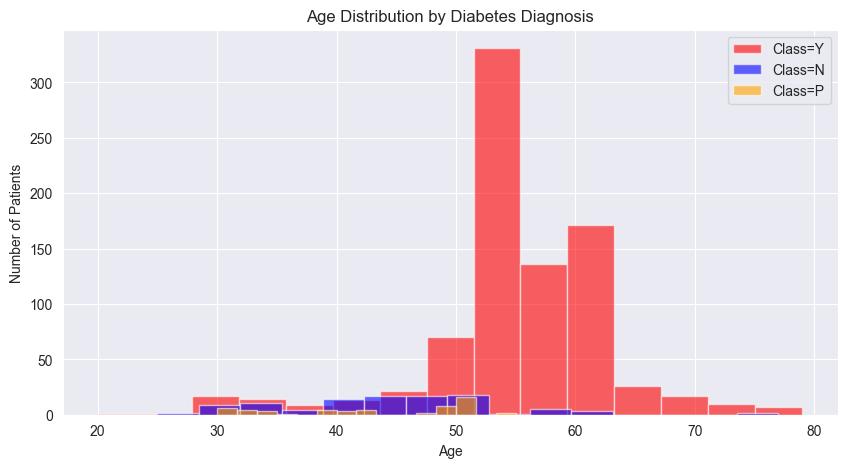

Percent of young diagnosed: 47.73%
Percent of young diagnosed out of the total diagnosed: 4.98%


In [52]:
#visualization
#Age distribution of diagnosis classes
plt.figure(figsize=(10,5))
for dclass, color in zip(['Y','N','P'],['red','blue','orange']):
    subset = df[df['CLASS_original']==dclass]
    plt.hist(subset['AGE'], bins=15, alpha=0.6, label=f'Class={dclass}', color=color)
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.title('Age Distribution by Diabetes Diagnosis')
plt.legend()
plt.show()

# What percentage of younger people are prone to be diagnosed with diabetes disease? 
young_cutoff = 40
young = df[df['AGE'] < young_cutoff] #total count of "young" people
young_diabetes = young[young['CLASS_original']=='Y'] # how many of them are diagnosed
percent_young_diabetes = len(young_diabetes) / len(young) * 100 if len(young) > 0 else None
print(f'Percent of young diagnosed: {percent_young_diabetes:.2f}%')

# how many of the total diagnosed people are considered young?
total_diagnosed = df[df['CLASS_original']=='Y']
percent_young = len(young_diabetes) / len(total_diagnosed) * 100 if len(young) > 0 else None
print(f'Percent of young diagnosed out of the total diagnosed: {percent_young:.2f}%')

CLASS_original   N   P    Y
Gender                     
F               64  17  354
M               39  36  490
percentage of females out of the total diagnosed 41.94%
percentage of males out of the total diagnosed 58.06%


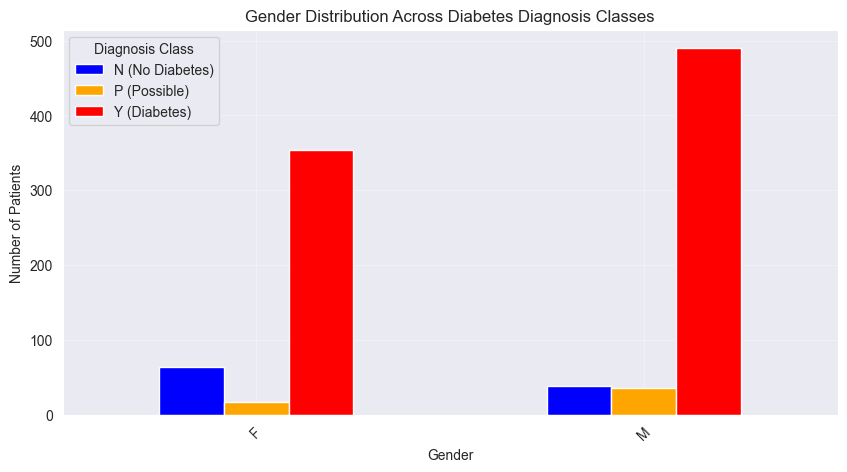

In [53]:
# Group by gender and class to find out which gender is more prone to diabetes
gender_counts = df.groupby(['Gender', 'CLASS_original']).size().unstack(fill_value=0)
print(gender_counts)

# in percentage:
female_diagnosed_percent = len(df.query("CLASS_original== 'Y' and Gender == 'F'")) / len(total_diagnosed) * 100
male_diagnosed_percent = len(df.query("CLASS_original == 'Y' and Gender == 'M'")) / len(total_diagnosed) * 100
print(f'percentage of females out of the total diagnosed {female_diagnosed_percent:.2f}%')
print(f'percentage of males out of the total diagnosed {male_diagnosed_percent:.2f}%')

# Create a grouped bar chart
gender_counts.plot(kind='bar', figsize=(10, 5), color=['blue', 'orange', 'red'])
plt.title('Gender Distribution Across Diabetes Diagnosis Classes')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.legend(title='Diagnosis Class', labels=['N (No Diabetes)', 'P (Possible)', 'Y (Diabetes)'])
plt.xticks(rotation=45)
plt.grid(alpha=0.3)  # Light grid
plt.show()

## Step 6: Select Numeric Columns for Outlier Detection


In [54]:
#drop id and number of patients because they will distort the results
num_col=df.select_dtypes(exclude='object').columns.drop(['ID', 'No_Pation','Gender_encoded','Class_N','Class_P','Class_Y'])
print (num_col)


Index(['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL',
       'BMI'],
      dtype='object')


## Step 7: Outlier Detection using IQR


In [55]:
#now we check for outliers
q1= df[num_col].quantile(0.25)
q3 = df[num_col].quantile(0.75)
iqr= q3-q1

outlier_mask = (df[num_col] < (q1 - 1.5 * iqr)) | (df[num_col] > (q3 + 1.5 * iqr))

outlier_counts = outlier_mask.sum()
print(outlier_counts)
# Detect rows where ANY column is an outlier
row_outlier_mask = outlier_mask.any(axis=1)

# Total number of outlier rows
outlier_count = row_outlier_mask.sum()

print(outlier_count)


AGE      98
Urea     65
Cr       52
HbA1c     6
Chol     27
TG       55
HDL      50
LDL      11
VLDL     74
BMI       3
dtype: int64
321


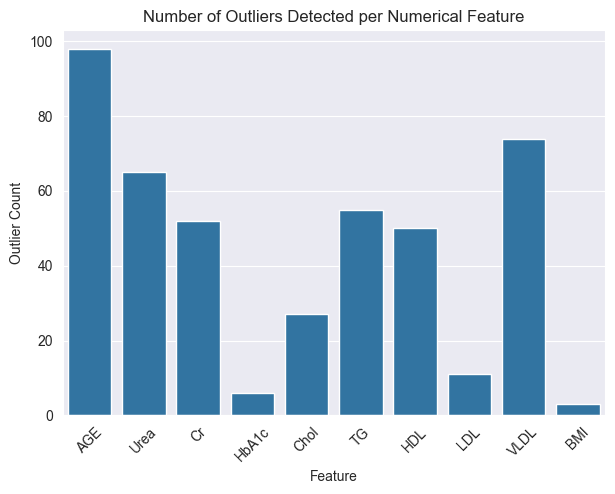

In [56]:
# --- Bar Plot of Outlier Counts ---
plt.figure(figsize=(7, 5))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values)
plt.title("Number of Outliers Detected per Numerical Feature")
plt.ylabel("Outlier Count")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

## Step 8: Visualize Outliers (Before Cleaning)


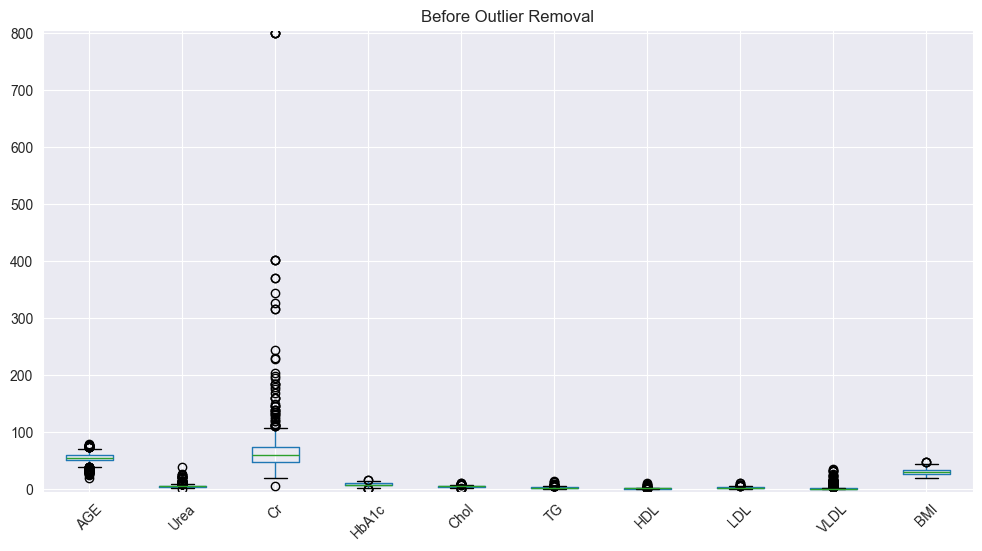

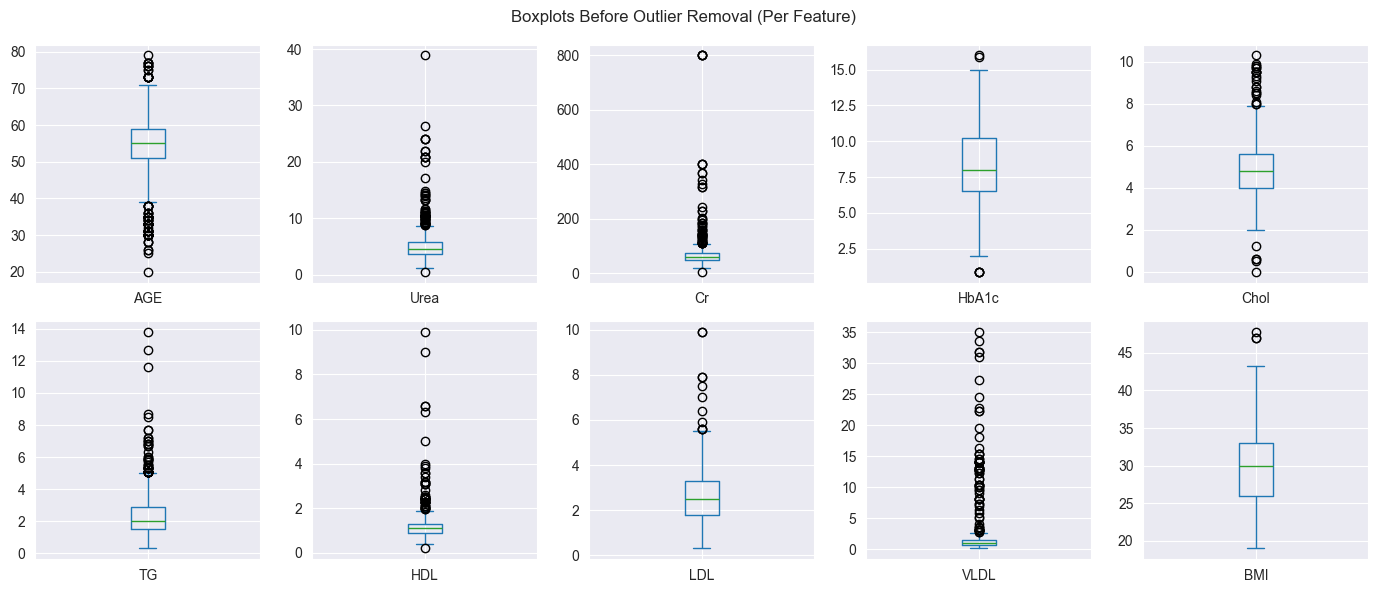

In [57]:
#visualizing the outliers

# Get global min and max from the original (before cleaning) DataFrame
ymin = df[num_col].min().min() -5
ymax = df[num_col].max().max() + 5

# --- Before removing outliers ---
plt.figure(figsize=(12,6))
df[num_col].boxplot()
plt.title("Before Outlier Removal")
plt.ylim(ymin, ymax)  # fix y scale
plt.xticks(rotation=45)
plt.savefig("visualization/Boxplot_before_outlier_removal.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Individual boxplots per feature (grid layout like after cleaning) ---
ax = df[num_col].plot.box(
    subplots=True,
    layout=(2, 5),            # Adjust depending on number of numeric features
    figsize=(14, 6),
    sharey=False,
    title="Boxplots Before Outlier Removal (Per Feature)"
)

plt.tight_layout()
plt.savefig("visualization/Boxplot_before_outlier_removal_subplots.png", dpi=300, bbox_inches='tight')
plt.show()


## Step 9: Mask and Impute Outliers


In [58]:
# df_cleaned = df[~outlier_mask.any(axis=1)]

#Mask outlier cells with NaN (ensure dtype can hold NaN)
df_masked = df.copy()

# Force ALL numeric feature columns to float64 so NaN is allowed (prevents FutureWarning)
df_masked = df_masked.astype({col: "float64" for col in num_col})

# Now it’s safe to insert NaN via mask
df_masked.loc[:, num_col] = df_masked.loc[:, num_col].mask(outlier_mask)

#Impute missing values (from outlier masking) with median
imputer = SimpleImputer(strategy="median")
imputed_values = imputer.fit_transform(df_masked[num_col])  # returns float64 array

df_cleaned = df_masked.copy()
df_cleaned.loc[:, num_col] = imputed_values


## Step 10: Evaluate Outlier Masking and Imputation


In [59]:
#######################################EVALUTAING OUTLIER MASKING AND IMPUTATION#######################################

#how many outliers were there
total_outliers = outlier_mask.sum().sum()
print(f"\nTotal outlier cells detected: {total_outliers}")
print(outlier_mask.sum().sort_values(ascending=False))

#how many NaNs introduced before imputation
print("\nNaNs introduced (before imputation):")
print(df_masked[num_col].isna().sum().sort_values(ascending=False))

#Check that imputation removed all NaNs
print("\nRemaining NaNs after imputation (should be 0):")
print(df_cleaned[num_col].isna().sum().sum())

# Check medians didn’t shift wildly
print(pd.DataFrame({
    'Median_before': df[num_col].median().round(3),
    'Median_after' : df_cleaned[num_col].median().round(3)
}))

#check means didn’t shift wildly
print(pd.DataFrame({
    'Mean_before': df[num_col].mean().round(3),
    'Mean_after' : df_cleaned[num_col].mean().round(3)
}))



Total outlier cells detected: 441
AGE      98
VLDL     74
Urea     65
TG       55
Cr       52
HDL      50
Chol     27
LDL      11
HbA1c     6
BMI       3
dtype: int64

NaNs introduced (before imputation):
AGE      98
VLDL     74
Urea     65
TG       55
Cr       52
HDL      50
Chol     27
LDL      11
HbA1c     6
BMI       3
dtype: int64

Remaining NaNs after imputation (should be 0):
0
       Median_before  Median_after
AGE             55.0          55.0
Urea             4.6           4.5
Cr              60.0          59.0
HbA1c            8.0           8.0
Chol             4.8           4.8
TG               2.0           2.0
HDL              1.1           1.1
LDL              2.5           2.5
VLDL             0.9           0.9
BMI             30.0          30.0
       Mean_before  Mean_after
AGE         53.528      54.946
Urea         5.125       4.562
Cr          68.943      59.767
HbA1c        8.281       8.294
Chol         4.863       4.789
TG           2.350       2.116
HDL      

## Step 11: Scatter Plots Before Outlier Removal


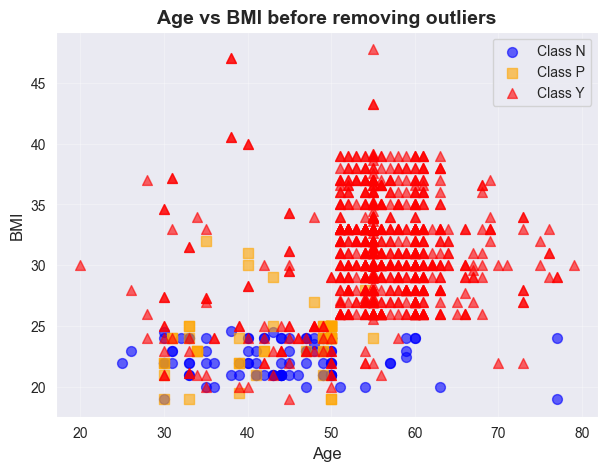

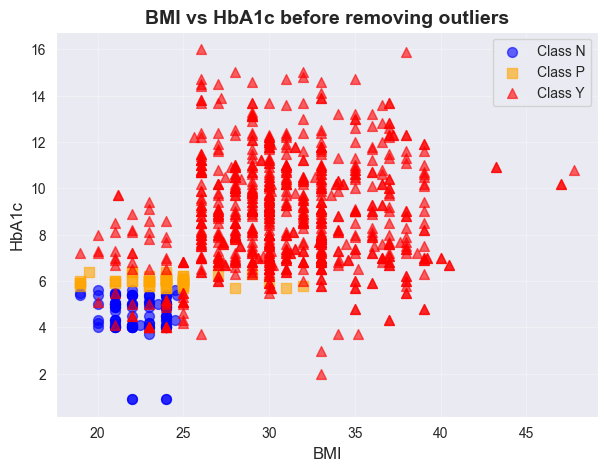

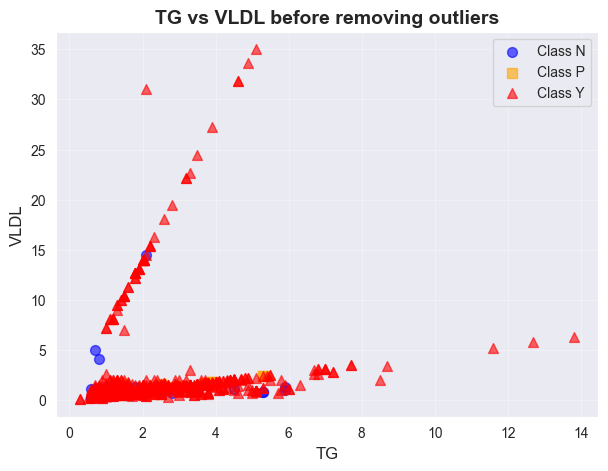

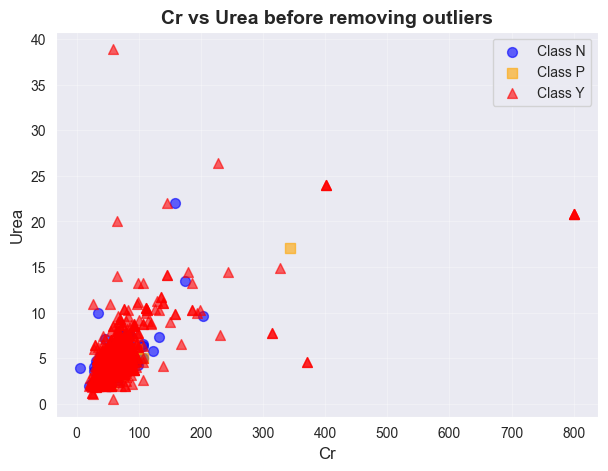

In [60]:
#######################################Scatter plots before removing outliers#######################################
plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS_original'] == dclass]
    plt.scatter(subset['AGE'], subset['BMI'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('Age', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.title('Age vs BMI before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/Age_vs_BMI_before_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS_original'] == dclass]
    plt.scatter(subset['BMI'], subset['HbA1c'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('BMI', fontsize=12)
plt.ylabel('HbA1c', fontsize=12)
plt.title('BMI vs HbA1c before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/BMI_vs_HbA1c_before_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS_original'] == dclass]
    plt.scatter(subset['TG'], subset['VLDL'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('TG', fontsize=12)
plt.ylabel('VLDL', fontsize=12)
plt.title('TG vs VLDL before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/TG_vs_VLDL_before_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS_original'] == dclass]
    plt.scatter(subset['Cr'], subset['Urea'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('Cr', fontsize=12)
plt.ylabel('Urea', fontsize=12)
plt.title('Cr vs Urea before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/Cr_vs_Urea_before_outliers.png", dpi=300, bbox_inches='tight')
plt.show()
#######################################Scatter plots before removing outliers#######################################


## Step 12 A: Boxplots After Outlier Imputation


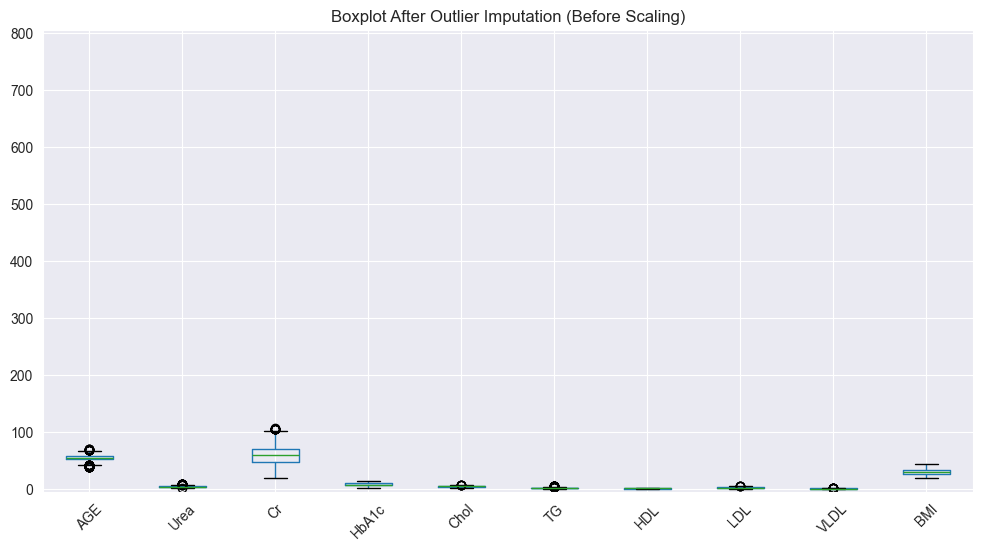

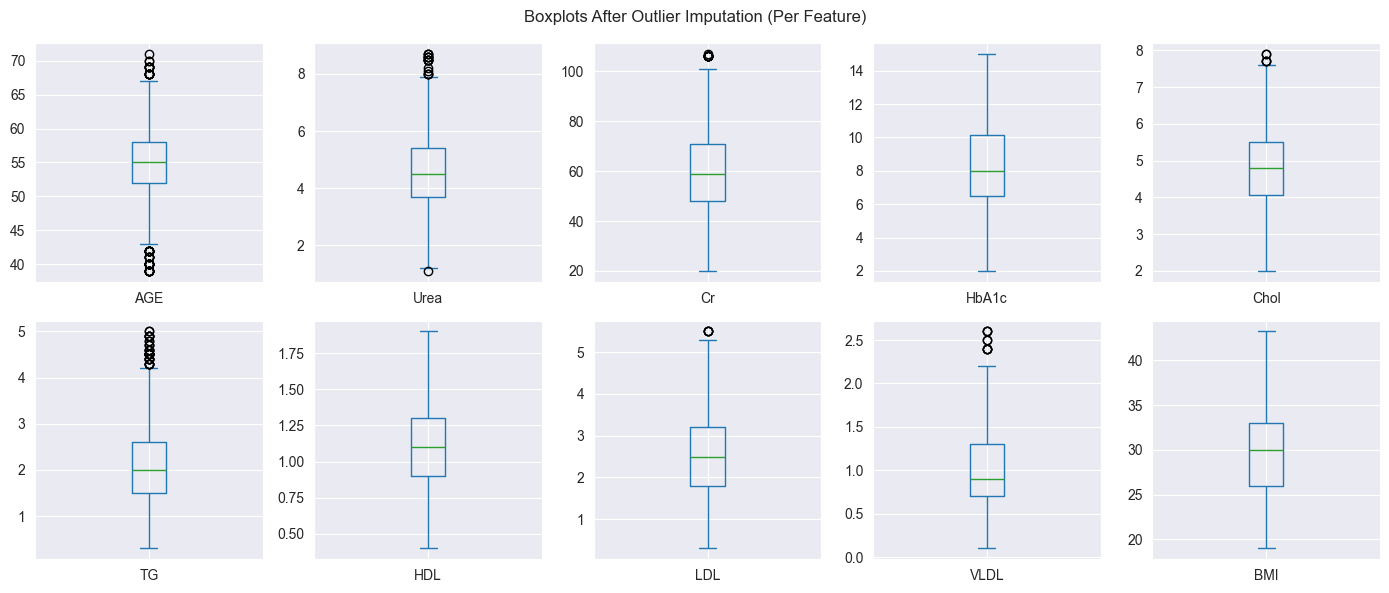

In [61]:
#######################################Scatter plots after removing outliers#######################################

#visualizing after removing outliers
plt.figure(figsize=(12,6))
df_cleaned[num_col].boxplot()
plt.title("Boxplot After Outlier Imputation (Before Scaling)")
plt.ylim(ymin, ymax)  # same y scale as 'before'
plt.xticks(rotation=45)
plt.savefig("visualization/Boxplot_after_outlier_imputation.png", dpi=300, bbox_inches='tight')
plt.show()

# Subplots for each numeric column
df_cleaned[num_col].plot.box(
    subplots=True,
    layout=(2, 5),
    figsize=(14, 6),
    sharey=False,
    title='Boxplots After Outlier Imputation (Per Feature)'
)
plt.tight_layout()
plt.savefig("visualization/Boxplot_after_outlier_imputation_subplots.png", dpi=300, bbox_inches='tight')
plt.show()


## Step 12 B: Scatter Plots After Outlier Imputation


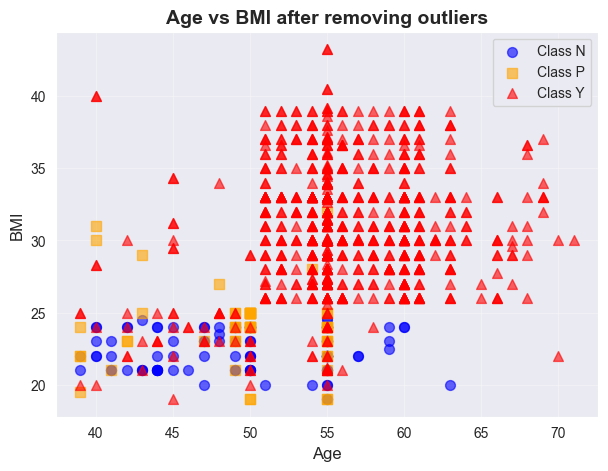

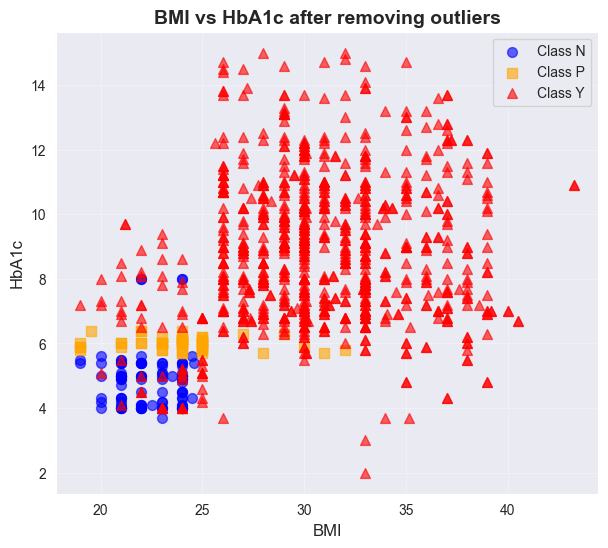

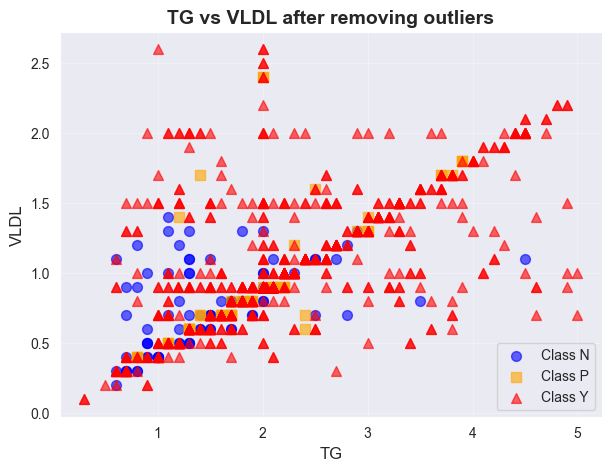

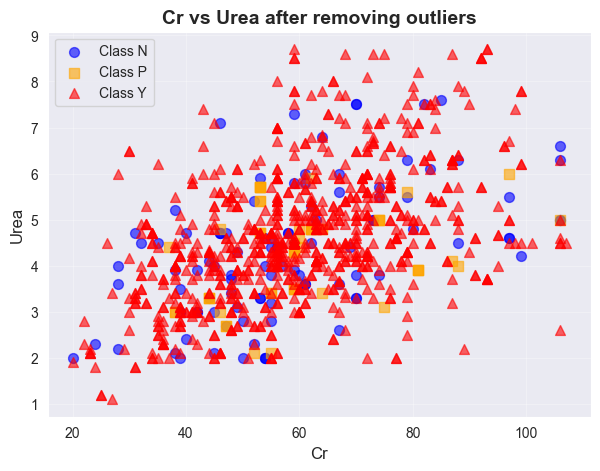

In [62]:
#Scatter plots after removing outliers
# Age vs BMI
plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS_original'] == dclass]
    plt.scatter(subset['AGE'], subset['BMI'], 
                alpha=0.6, c=color, label=f'Class {dclass}', 
                marker=marker, s=50)

plt.xlabel('Age', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.title('Age vs BMI after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/Age_vs_BMI_after_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

# BMI vs HbA1c
plt.figure(figsize=(7, 6))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS_original'] == dclass]
    plt.scatter(subset['BMI'], subset['HbA1c'], 
                alpha=0.6, c=color, label=f'Class {dclass}', 
                marker=marker, s=50)

plt.xlabel('BMI', fontsize=12)
plt.ylabel('HbA1c', fontsize=12)
plt.title('BMI vs HbA1c after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/BMI_vs_HbA1c_after_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS_original'] == dclass]
    plt.scatter(subset['TG'], subset['VLDL'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('TG', fontsize=12)
plt.ylabel('VLDL', fontsize=12)
plt.title('TG vs VLDL after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/TG_vs_VLDL_after_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS_original'] == dclass]
    plt.scatter(subset['Cr'], subset['Urea'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('Cr', fontsize=12)
plt.ylabel('Urea', fontsize=12)
plt.title('Cr vs Urea after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/Cr_vs_Urea_after_outliers.png", dpi=300, bbox_inches='tight')
plt.show()
#######################################Scatter plots after removing outliers#######################################


## Step 13: Scale and Visualize Final Features


In [ ]:
#now scaling
scaler=MinMaxScaler()
df_cleaned[num_col] = scaler.fit_transform(df_cleaned[num_col])
df_cleaned[num_col].describe()

df_cleaned[num_col].hist(bins=20, figsize=(15,10))
plt.suptitle("Histogram of Scaled Features")
plt.savefig("visualization/Histogram_scaled_features.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(df_cleaned[num_col].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Scaled Features")
plt.savefig("visualization/Correlation_heatmap_scaled_features.png", dpi=300, bbox_inches='tight')
plt.show()


### Step 14: Data Splitting

In [41]:
from sklearn.model_selection import train_test_split

#define feature columns and target
feature_cols = list(num_col) + ['Gender_encoded']


#data splitting
# Target column (the original version before one-hot encoding)
y = df_cleaned['CLASS_original']

# Feature set (numerical + encoded gender)
X = df_cleaned[num_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (800, 10)
Testing data shape: (200, 10)


### Step 15: Random Forest Model Training


In [42]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


# Parameter ranges to search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

#Base Model
rf_base = RandomForestClassifier(random_state=42)

#Stratified Cross Validation keeps class proportions in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search CV

rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=40,              # number of random combos to try
    scoring='accuracy',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1               # use all cores
)


rf_random.fit(X_train, y_train)
print("Random Forest model trained.")

print("Best CV score:", rf_random.best_score_)
print("Best parameters:")
for k, v in rf_random.best_params_.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Random Forest model trained.
Best CV score: 0.9825000000000002
Best parameters:
  n_estimators: 100
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: log2
  max_depth: None
  class_weight: balanced_subsample
  bootstrap: True


### Step 16: Evaluate Model

Tuned Random Forest - Test Accuracy: 0.995

Classification Report:

              precision    recall  f1-score   support

           N       1.00      1.00      1.00        21
           P       1.00      0.90      0.95        10
           Y       0.99      1.00      1.00       169

    accuracy                           0.99       200
   macro avg       1.00      0.97      0.98       200
weighted avg       1.00      0.99      0.99       200



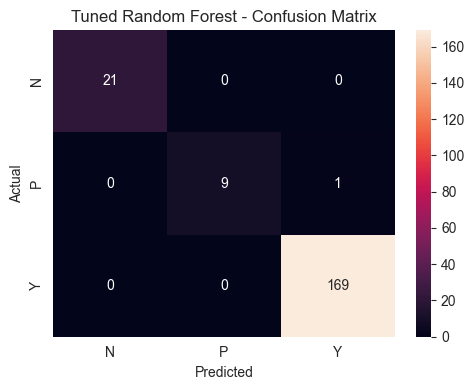

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Best tuned model
best_rf = rf_random.best_estimator_

# Predictions on test sets
y_pred_best = best_rf.predict(X_test)

print("Tuned Random Forest - Test Accuracy:", round(accuracy_score(y_test, y_pred_best), 4))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best, labels=best_rf.classes_)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=best_rf.classes_,
            yticklabels=best_rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Tuned Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()


Class mapping: {'N': np.int64(0), 'P': np.int64(1), 'Y': np.int64(2)}
Testing different k values on test set...
k= 1: Test Accuracy = 0.9550
k= 3: Test Accuracy = 0.9200
k= 5: Test Accuracy = 0.9150
k= 7: Test Accuracy = 0.9250
k= 9: Test Accuracy = 0.9250
k=11: Test Accuracy = 0.9200
k=13: Test Accuracy = 0.9150
k=15: Test Accuracy = 0.9200

Elbow point detected at k=3 (k=1 excluded)
Accuracy at elbow (k=3): 0.9200


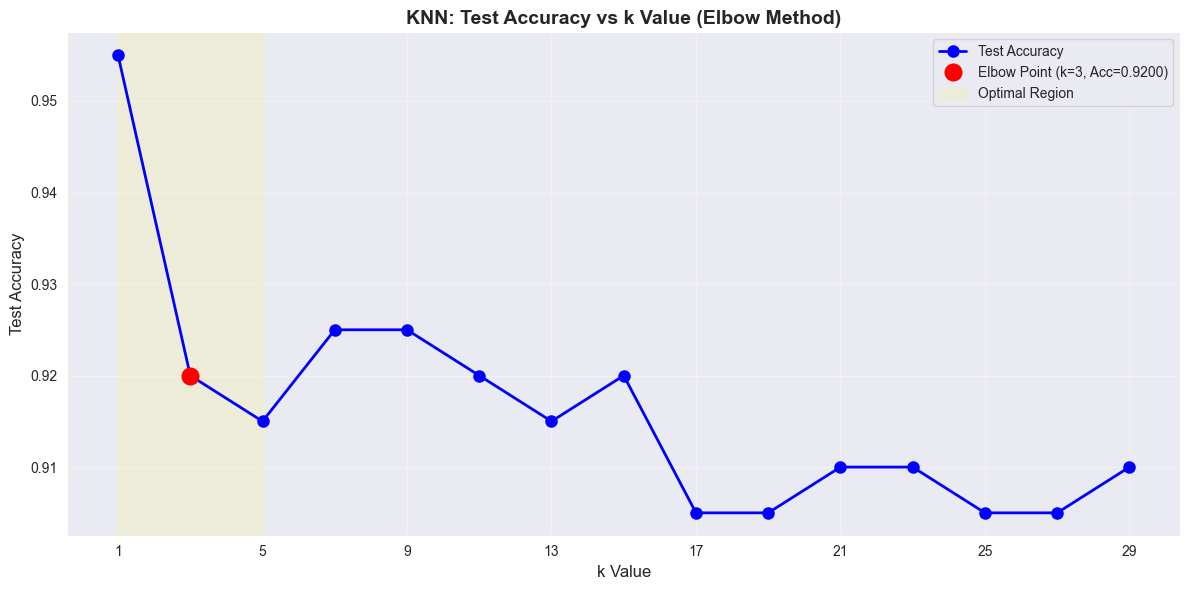


Training final KNN model with k=3 (elbow point)...

Accuracy with k=3: 0.9200 (92.00%)

Confusion Matrix:
[[ 15   1   5]
 [  4   5   1]
 [  3   2 164]]

Classification Report:
              precision    recall  f1-score   support

           N       0.68      0.71      0.70        21
           P       0.62      0.50      0.56        10
           Y       0.96      0.97      0.97       169

    accuracy                           0.92       200
   macro avg       0.76      0.73      0.74       200
weighted avg       0.92      0.92      0.92       200


=== Detailed Per-Class Metrics ===
Class N:
  Precision: 0.6818 - Of predicted N, 68.2% were correct
  Recall:    0.7143 - Found 71.4% of actual N cases

Class P:
  Precision: 0.6250 - Of predicted P, 62.5% were correct
  Recall:    0.5000 - Found 50.0% of actual P cases

Class Y:
  Precision: 0.9647 - Of predicted Y, 96.5% were correct
  Recall:    0.9704 - Found 97.0% of actual Y cases



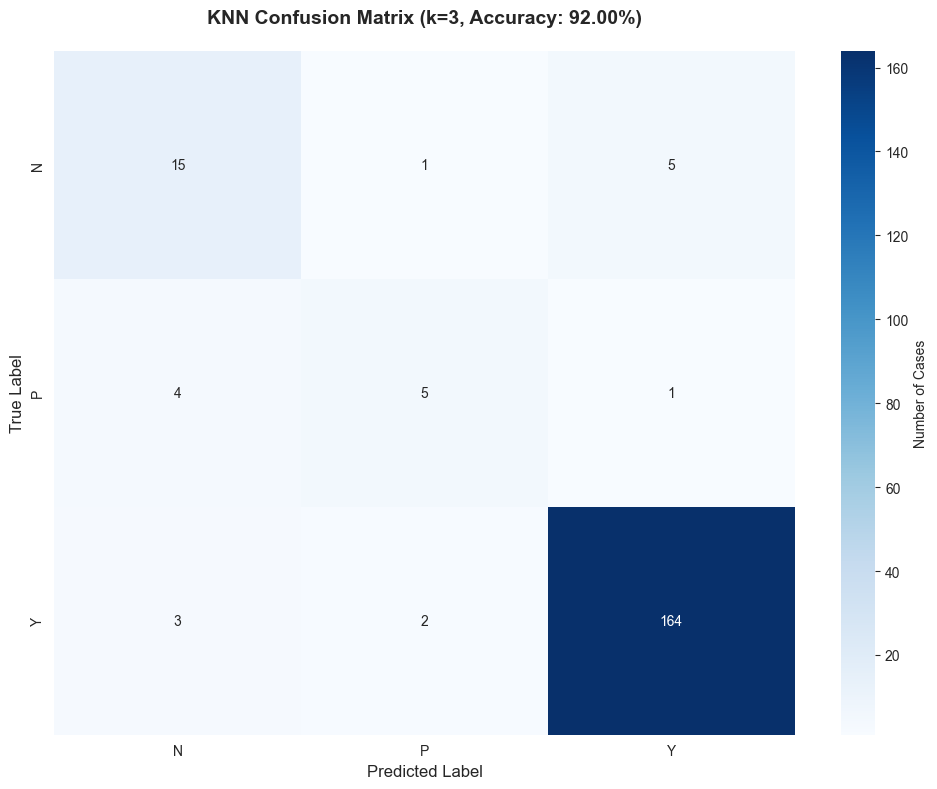


✓ Selected k=3 based on elbow method (k=1 excluded)
✓ Test accuracy: 92.00%
✓ Good balance between model simplicity and performance


In [44]:
### %md
# Step 15: KNN Classifier - Find Best k using Test Accuracy Graph
# %md

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier



label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

#### 15.1: Test different k values on test set

# Try different k values
k_values = list(range(1, 31, 2))  # Odd numbers from 1 to 29
test_accuracies = []

print("Testing different k values on test set...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train_encoded)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    test_accuracies.append(accuracy)

    if k <= 15:  # Print first 15
        print(f"k={k:2d}: Test Accuracy = {accuracy:.4f}")

#### 15.2: Find elbow point in test accuracy graph (excluding k=1)

# Find elbow point (where adding more neighbors doesn't help much)
# Exclude k=1 from being considered as elbow point
def find_elbow_point_excluding_k1(k_values, accuracies, threshold=0.01):
    """
    Find elbow point where accuracy gain becomes minimal
    Excludes k=1 from being selected as the elbow
    threshold: minimum improvement to consider it worth increasing k
    """
    # Find max accuracy excluding k=1
    acc_without_k1 = accuracies[1:]  # Exclude k=1
    max_acc = max(acc_without_k1)

    # Start from k=3 (index 1 in k_values since k_values[0]=1, k_values[1]=3)
    for i in range(1, len(k_values)):  # Start from index 1 (k=3)
        k = k_values[i]
        acc = accuracies[i]

        # If this k gives near-maximum accuracy, check if it's the elbow
        if acc >= max_acc * (1 - threshold):
            # Check if this is the elbow (next point doesn't improve much)
            if i < len(accuracies) - 1:
                improvement = accuracies[i + 1] - acc
                if improvement < threshold * 0.5:  # Very small improvement
                    return k
    # If no clear elbow found, return k=3 as default
    return k_values[1]  # k=3

# Find elbow point excluding k=1
elbow_k = find_elbow_point_excluding_k1(k_values, test_accuracies, threshold=0.02)
print(f"\nElbow point detected at k={elbow_k} (k=1 excluded)")
print(f"Accuracy at elbow (k={elbow_k}): {test_accuracies[k_values.index(elbow_k)]:.4f}")

#### 15.3: Plot test accuracy vs k graph (without vertical line)

plt.figure(figsize=(12, 6))

# Plot accuracy curve
plt.plot(k_values, test_accuracies, 'bo-', linewidth=2, markersize=8, label='Test Accuracy')

# Mark the elbow point (only if not k=1)
if elbow_k != 1:
    elbow_accuracy = test_accuracies[k_values.index(elbow_k)]
    plt.plot(elbow_k, elbow_accuracy, 'ro', markersize=12,
             label=f'Elbow Point (k={elbow_k}, Acc={elbow_accuracy:.4f})')

# Highlight region around elbow (if not k=1)
if elbow_k > 1 and elbow_k < 30:
    plt.axvspan(elbow_k - 2, elbow_k + 2, alpha=0.1, color='yellow', label='Optimal Region')

plt.xlabel('k Value', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('KNN: Test Accuracy vs k Value (Elbow Method)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(k_values[::2])  # Show every other k value
plt.tight_layout()
plt.show()

#### 15.4: Train final model with elbow k (k=3)

# Use the elbow k found (which won't be 1)
final_k = elbow_k
print(f"\nTraining final KNN model with k={final_k} (elbow point)...")

knn_final = KNeighborsClassifier(n_neighbors=final_k)
knn_final.fit(X_train, y_train_encoded)

# Make predictions
y_pred = knn_final.predict(X_test)

#### 15.5: Evaluate model with elbow k

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\nAccuracy with k={final_k}: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Show detailed classification report
print("\nClassification Report:")
report = classification_report(y_test_encoded, y_pred,
                               target_names=label_encoder.classes_,
                               output_dict=True)
print(classification_report(y_test_encoded, y_pred,
                            target_names=label_encoder.classes_))

# Extract precision and recall for each class
print("\n=== Detailed Per-Class Metrics ===")
for i, class_name in enumerate(label_encoder.classes_):
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']

    print(f"Class {class_name}:")
    print(f"  Precision: {precision:.4f} - Of predicted {class_name}, {precision * 100:.1f}% were correct")
    print(f"  Recall:    {recall:.4f} - Found {recall * 100:.1f}% of actual {class_name} cases")
    print()

#### 15.6: Visualize confusion matrix

plt.figure(figsize=(10, 8))

# Create confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Number of Cases'})

plt.title(f'KNN Confusion Matrix (k={final_k}, Accuracy: {accuracy * 100:.2f}%)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n✓ Selected k={final_k} based on elbow method (k=1 excluded)")
print(f"✓ Test accuracy: {accuracy * 100:.2f}%")
print("✓ Good balance between model simplicity and performance")

### Logistic Regression Model

Precision: 0.86
Recall: 0.91
Accuracy: 90.50%
Confusion Matrix:
 [[ 13   1   7]
 [  3   0   7]
 [  1   0 168]]


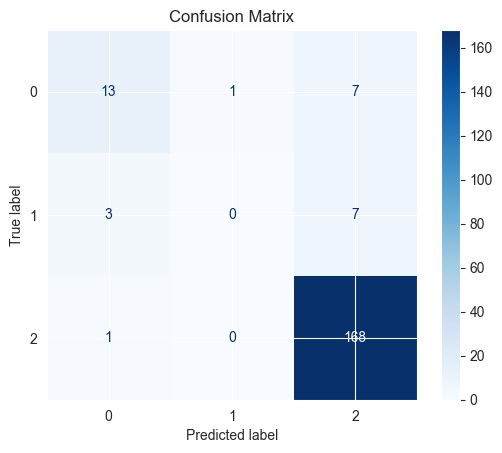

In [45]:
logRegModel= LogisticRegression()
logRegModel.fit(X_train, y_train)

y_pred = logRegModel.predict(X_test) # Predict class labels
y_proba = logRegModel.predict_proba(X_test) # Predict class probabilities

precision = metrics.precision_score(y_test, y_pred,  average='weighted')
recall = metrics.recall_score(y_test, y_pred,  average='weighted')
accuracy = metrics.accuracy_score(y_test, y_pred) * 100
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}%" )
print("Confusion Matrix:\n", confusion_matrix )

# Plot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix")
plt.show()

## Decision Tree


DECISION TREE IMPLEMENTATION


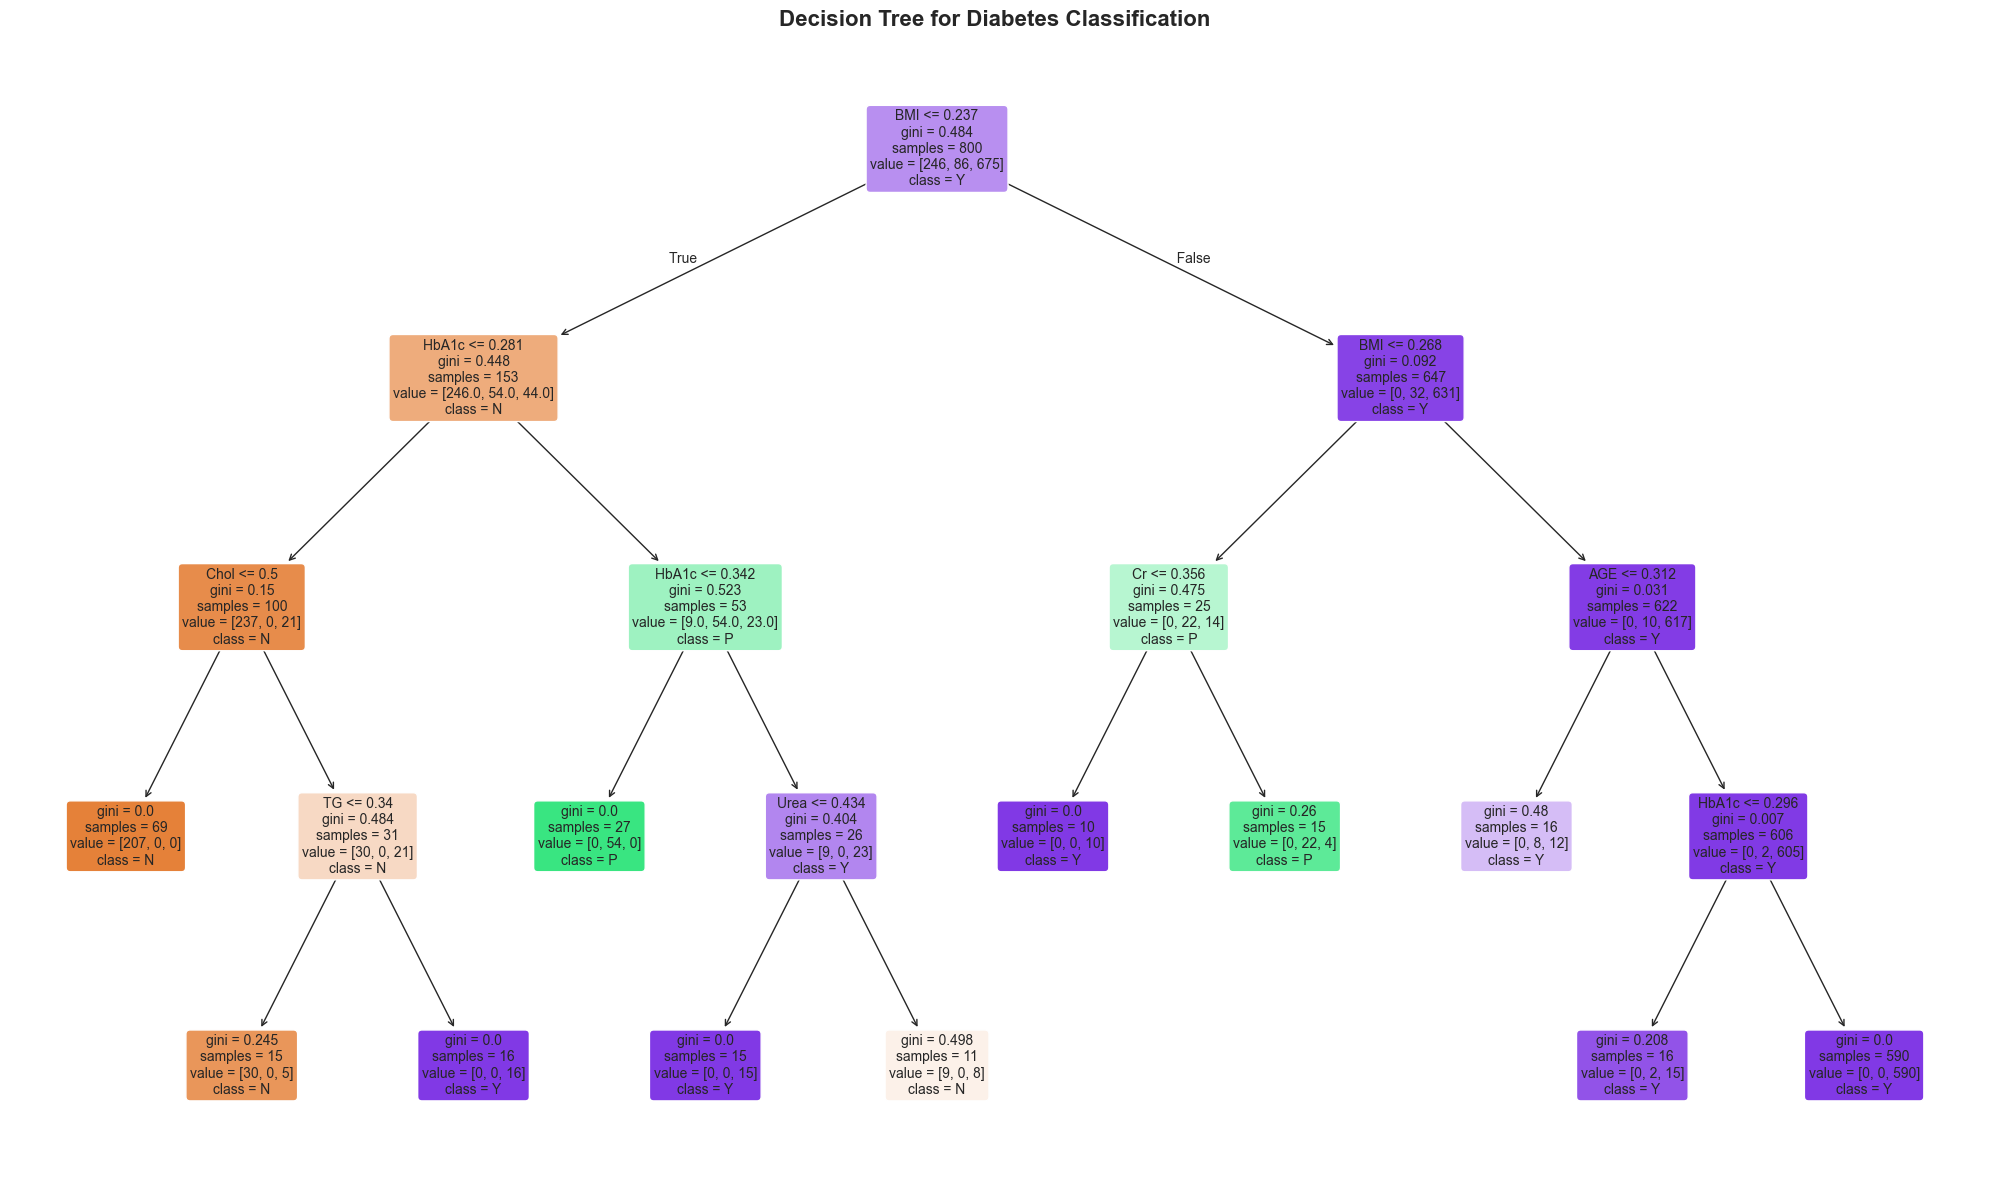


Accuracy: 0.9700 (97.00%)

First 10 predictions (Actual -> Predicted):
  P -> P
  N -> N
  Y -> Y
  Y -> Y
  N -> N
  Y -> Y
  Y -> Y
  Y -> Y
  Y -> Y
  Y -> Y

DETAILED EVALUATION METRICS

Test set size: 200
Class distribution in test set:
CLASS_original
N     21
P     10
Y    169
Name: count, dtype: int64

CONFUSION MATRIX

                Predicted
                 N     P     Y
Actual N:     21     0     0
        P:      0     9     1
        Y:      5     0   164

Key: N = Normal, P = Prediabetes, Y = Diabetes

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           N       0.81      1.00      0.89        21
           P       1.00      0.90      0.95        10
           Y       0.99      0.97      0.98       169

    accuracy                           0.97       200
   macro avg       0.93      0.96      0.94       200
weighted avg       0.97      0.97      0.97       200


=== Detailed Per-Class Metrics ===

Class N:
  Precision: 0.8077 - Of p

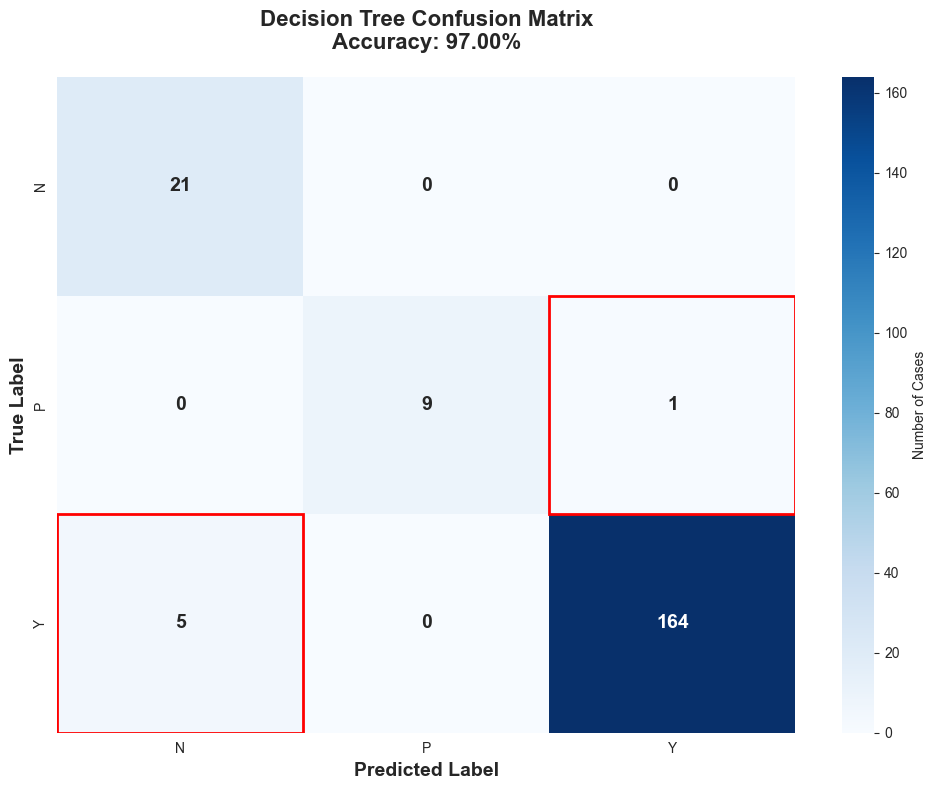


ADDITIONAL METRICS CALCULATION

=== Specificity and Error Analysis ===

Class N:
  Specificity: 0.9721 - Correctly identified 97.2% of non-N cases
  False Positive Rate: 0.0279
  False Negative Rate: 0.0000

Class P:
  Specificity: 1.0000 - Correctly identified 100.0% of non-P cases
  False Positive Rate: 0.0000
  False Negative Rate: 0.1000

Class Y:
  Specificity: 0.9677 - Correctly identified 96.8% of non-Y cases
  False Positive Rate: 0.0323
  False Negative Rate: 0.0296

FEATURE IMPORTANCE

Top 10 Most Important Features:
Feature  Importance
    BMI    0.658282
  HbA1c    0.228618
     TG    0.035841
   Chol    0.030823
     Cr    0.022974
    AGE    0.013538
   Urea    0.009923
    HDL    0.000000
    LDL    0.000000
   VLDL    0.000000


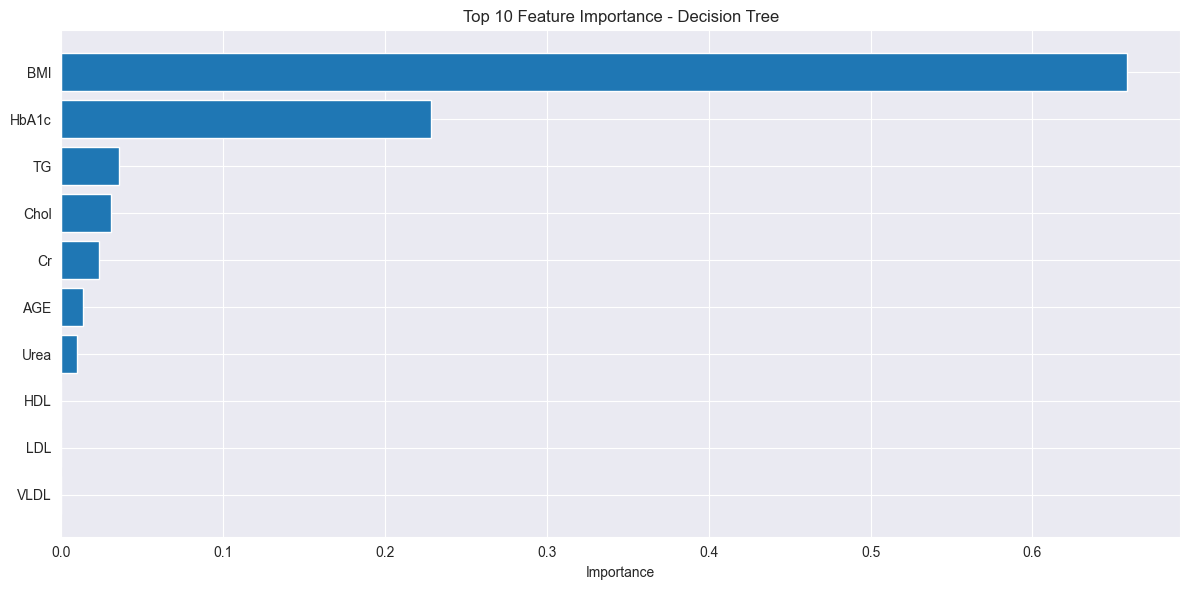


DECISION TREE IMPLEMENTATION COMPLETE


In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\n" + "="*60)
print("DECISION TREE IMPLEMENTATION")
print("="*60)

# Create and train decision tree
clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_leaf=10,
    class_weight={'N': 3, 'P': 2, 'Y': 1}
)

clf.fit(X_train, y_train)

# Display the tree
plt.figure(figsize=(20, 12))
plot_tree(clf,
          feature_names=X_train.columns.tolist(),
          class_names=sorted(y_train.unique()),
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree for Diabetes Classification", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("visualization/decision_tree_structure.png", dpi=300, bbox_inches='tight')
plt.show()

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Display sample predictions
print("\nFirst 10 predictions (Actual -> Predicted):")
for i in range(min(10, len(y_test))):
    print(f"  {y_test.iloc[i]} -> {y_pred[i]}")

print("\n" + "="*60)
print("DETAILED EVALUATION METRICS")
print("="*60)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['N', 'P', 'Y'])

print(f"\nTest set size: {len(y_test)}")
print(f"Class distribution in test set:")
print(y_test.value_counts().sort_index())

print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

# Simple display
print("\n                Predicted")
print("                 N     P     Y")
print("Actual N:  {:5d} {:5d} {:5d}".format(cm[0,0], cm[0,1], cm[0,2]))
print("        P:  {:5d} {:5d} {:5d}".format(cm[1,0], cm[1,1], cm[1,2]))
print("        Y:  {:5d} {:5d} {:5d}".format(cm[2,0], cm[2,1], cm[2,2]))
print("\nKey: N = Normal, P = Prediabetes, Y = Diabetes")

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

# Generate report  and store it
report = classification_report(y_test, y_pred,
                               target_names=['N', 'P', 'Y'],
                               output_dict=True)

# Print the formatted report
print(classification_report(y_test, y_pred, target_names=['N', 'P', 'Y']))

print("\n=== Detailed Per-Class Metrics ===")
# Extract from the already-generated report
for class_name in ['N', 'P', 'Y']:
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']
    f1 = report[class_name]['f1-score']
    support = report[class_name]['support']

    print(f"\nClass {class_name}:")
    print(f"  Precision: {precision:.4f} - Of predicted {class_name}, {precision*100:.1f}% were correct")
    print(f"  Recall:    {recall:.4f} - Found {recall*100:.1f}% of actual {class_name} cases")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Support:   {support} samples")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['N', 'P', 'Y'],
                 yticklabels=['N', 'P', 'Y'],
                 cbar_kws={'label': 'Number of Cases'},
                 annot_kws={"size": 14, "weight": "bold"})

plt.title(f'Decision Tree Confusion Matrix\nAccuracy: {accuracy*100:.2f}%',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')

# Highlight misclassifications with red borders
for i in range(3):
    for j in range(3):
        if i != j and cm[i, j] > 0:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False,
                                       edgecolor='red', lw=2))

plt.tight_layout()
plt.savefig("visualization/decision_tree_confusion_matrix_ACTUAL.png",
            dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("ADDITIONAL METRICS CALCULATION")
print("="*60)

# Calculate specificity and other metrics from confusion matrix
print("\n=== Specificity and Error Analysis ===")

# For each class, calculate specificity (True Negative )
classes = ['N', 'P', 'Y']
for idx, class_name in enumerate(classes):
    # True negatives: sum of all elements except row and column of current class
    tn = cm.sum() - (cm[idx, :].sum() + cm[:, idx].sum() - cm[idx, idx])
    # False positives: sum of column except the diagonal
    fp = cm[:, idx].sum() - cm[idx, idx]

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\nClass {class_name}:")
    print(f"  Specificity: {specificity:.4f} - Correctly identified {specificity*100:.1f}% of non-{class_name} cases")

    # Error rates
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = report[class_name]['recall']  # 1 - recall is miss rate
    print(f"  False Positive Rate: {false_positive_rate:.4f}")
    print(f"  False Negative Rate: {1 - report[class_name]['recall']:.4f}")

# Feature Importance
print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("visualization/decision_tree_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("DECISION TREE IMPLEMENTATION COMPLETE")
print("="*60)